In [124]:
"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function A_step(q, p, h)
    q = q + h * p
    return q
end

"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function B_step(p, q, h, grad_U, data, N, n)
    F = - grad_U(data, q, N, n)
    p = p + h * F
    return p
end

"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function O_step(p, h, phi, A, beta)
    R = randn(length(p))
    if typeof(phi) == Matrix{Float64}
        alpha = alpha = exp(- h * phi)
        p = alpha * p + sqrt.(A ./ (phi .* beta)) * sqrt.(1 .- alpha ^ 2) * R
    elseif phi == 0 
        p = p + sqrt(h) * sqrt(2 * A / beta)
    else
        alpha = alpha = exp(- h * phi)
        p = alpha * p + sqrt(A / (beta * phi)) * sqrt(1 - alpha ^ 2) * R
    end

    return p

end

"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function D_step(p, h, xi, mu, beta)
    xi = xi + (dot(p, p) - length(p) / beta) * h / mu
    return xi
end

"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function C_step(q, I, N, n, grad_U, t, data)
    g_theta_mean = grad_U(data, q, N, n)
    V_diagonal = zeros(length(q))
    
    for i in 1:length(data)
        g_theta_i = grad_U([data[i]], q, N, n) .- g_theta_mean
        V_diagonal .+= g_theta_i .^ 2
    end
    
    V = Diagonal(V_diagonal ./ (n-1))

    kappa = 1 / t
    I = (1 - kappa) * I + kappa * V

    return I
end

C_step

In [125]:
"""
    step(q, p, h, A, beta, force[, xi])

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""

function BAOAB_step(q, p, h, integrator, steps, N, n, A, beta, data, grad_U, xi, I, t)
    phi = A
    p = B_step(p, q, h / 2, grad_U, data, N, n)
    q = A_step(q, p, h / 2)
    p = O_step(p, h, phi, A, beta)
    q = A_step(q, p, h / 2)
    p = B_step(p, q, h / 2, grad_U, data, N, n)
    return q, p
end

function step_function(q, p, h, integrator, steps, N, n, A, beta, data, grad_U, xi, I, t)
    for s in steps 
        occurences = count(x -> x == s, steps)
        if s == "A"
            q = A_step(q, p, h / occurences)
        elseif s == "B"
            p = B_step(p, q, h / occurences, grad_U, data, N, n)
        elseif s == "O"
            if integrator == "SGLD"
                phi = A
            elseif integrator == "CCAdL"
                phi = (h / (2 * occurences)) * beta * (N^2 / n) * I .+ xi
            elseif integrator == "SGNHT"
                phi = xi
            end
            p = O_step(p, h/occurences, phi, A, beta)
        elseif s == "D"
            mu = 1
            xi = D_step(p, h, xi, mu, beta)
        elseif s == "C"
            I = C_step(q, I, N, n, grad_U, t, data)
        end
    end

    return q, p
end



"""
    name(args)

Description: 

# Arguments
- 'arg::Type': Desc
- 'arg::Type': Desc

# Examples
```jldoctest
julia> name(args)
expected_output
```
"""
function run_simulation(q0, p0, Nsteps, h, integrator, steps, subset_prop, step_function, grad_U, data, A, beta, xi0, I0)
    q_traj = zeros(length(q0),Nsteps)
    p_traj = zeros(length(q0),Nsteps)
    t_traj = zeros(Nsteps)

    q = copy(q0)
    p = copy(p0)
    xi = copy(xi0)
    I = copy(I0)
    t = 0.0

    N = size(data,1)
    n = Int(round(N * subset_prop))

    for i in 1:Nsteps
        idx = randperm(N)[1:n]
        samples = data[idx,:]
        q, p = step_function(q, p, h, integrator, steps, N, n, A, beta, samples, grad_U, xi, I, t)

        t += h
        
        q_traj[:,i] = q
        p_traj[:,i] = p
        t_traj[i] = t
    end

    return q_traj, p_traj, t_traj
end

run_simulation

In [126]:
function model2_grad_U(data, w, N, n)
    # 2nd model - Large Scale Bayesian Logistic Regression
    x = data[:, 1:size(data, 2)-1]
    y = data[:, size(data, 2)]

    w_old = w

    sum = zeros(size(data, 2)-1)
    for i in 1:length(y)
        a = exp(- y[i] * dot(w, x[i, :]))
        #sum = sum .+ y[i] * x[i, :] * a / (1 + a)
        sum = sum .+ (y[i] * x[i, :] / (1 + a))
    end
    #w = w .- N/n * sum

    w = sign.(w) .* sum * N/n

    #for i in 1:length(y)
        #a = exp(- y[i] * dot(w_old, x[i, :]))
        #w = w .- (N / n * y[i] * x[i, :] * a / (1 + a))
    #end

    return w

end

model2_grad_U (generic function with 1 method)

In [127]:
using MLDatasets
using LinearAlgebra

# Load MNIST training data
train_x, train_y = MNIST(split=:train)[:]
ind = findall(x -> x == 7 || x == 9, train_y)
y_train = train_y[ind]
y_train = ifelse.(y_train .== 7, 1, 0)
x_train = transpose(reshape(train_x, size(train_x, 1)*size(train_x, 2), size(train_x, 3))[:, ind])

# Normalize the pixel values to the range [0, 1]
x_train = x_train / 255.0


# Load MNIST test data
test_x, test_y = MNIST(split=:test)[:]
ind = findall(x -> x == 7 || x == 9, test_y)
y_test = test_y[ind]
y_test = ifelse.(y_test .== 7, 1, 0)
x_test = transpose(reshape(test_x, size(test_x, 1)*size(test_x, 2), size(test_x, 3))[:, ind])
# Normalize the pixel values to the range [0, 1]
x_test = x_test / 255.0


# Number of features in the original dataset
n_features_original = size(x_train, 2)

# Generate a random projection matrix
n_components = 100
random_projection_matrix = randn(n_features_original, n_components)

# Project the features onto the random projection matrix
x_train = x_train * random_projection_matrix

# Project the features onto the random projection matrix
x_test = x_test * random_projection_matrix

train = hcat(x_train, y_train)
test = hcat(x_test, y_test)


2037×785 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [138]:
using Random, Statistics
# Initialize one walker
q0 = randn(size(x_train, 2))
p0 = randn(size(x_train, 2))

Nsteps = 1000000
h = 0.001
A = 5
beta = 1.0
subset_prop = 0.025

p_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps, h, "SGLD", "BAOAB", subset_prop, BAOAB_step, model2_grad_U, train, A, beta, 1, 1)

([-0.4796327876028246 -0.4795391083095261 … 36.87726886361244 36.87878044545785; 0.07022257155940742 0.06884295029921536 … -28.322312786189595 -28.323797772694753; … ; 0.5085802479832174 0.5071380207486228 … -14.224261378277294 -14.223922262078414; -0.5198675517060175 -0.518152966467306 … 13.68274091642716 13.683469929555374], [0.0021903960503073527 0.18516819054658623 … 1.4856495969866335 1.5375140938279788; -1.4407274968905979 -1.318515023493521 … -1.4998347799988356 -1.4701382303199462; … ; -1.5042207832257255 -1.380233685963695 … 0.31877935874903374 0.3594530390111933; 1.6741799030036946 1.7549905744190955 … 0.7202280716699776 0.7377981847542856], [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002  …  999.9909999832653, 999.9919999832653, 999.9929999832652, 999.9939999832652, 999.9949999832652, 999.9959999832652, 999.9969999832651, 999.9979999832651, 999.9989999832651, 999.9999999832651])

In [139]:
w = mean(p_traj[:, 100000:Nsteps], dims=2)
#w = mean(p_traj, dims=2)

function sigmoid(z)
    return 1.0 ./ (1.0 .+ exp.(-z))
end

function predict(features, weights)
    # Calculate the linear combination of features and weights
    z = features * weights

    # Apply the logistic function to get the probability
    probabilities = sigmoid(z)
    println(probabilities)
    # Apply threshold (0.5) for binary classification
    return probabilities .>= 0.5
end

# Predict the labels for the test set using the obtained parameters 'w'
predicted_labels = predict(x_test, w)

# Calculate accuracy
accuracy = sum(predicted_labels .== y_test) / length(y_test)

println("Accuracy on the test set: ", accuracy)

[0.500000322431704; 0.4999660409372178; 0.4999900827367521; 0.5000060977600732; 0.5000069108223774; 0.5000090681009505; 0.49998812336723947; 0.5000019951513014; 0.4999895088358257; 0.5000010212814255; 0.500000977424675; 0.5000125562172518; 0.5000016007372603; 0.49999956479707397; 0.49999480281352965; 0.4999959087886839; 0.4999883254425218; 0.5000100108215129; 0.4999884512984606; 0.49999736498872305; 0.49999982762946626; 0.49999238311945315; 0.5000021193077724; 0.4999918562556476; 0.5000043342625206; 0.500006105157086; 0.4999781060864712; 0.5000035504411251; 0.49998968951441547; 0.5000008726850086; 0.500003160635668; 0.4999969985130705; 0.5000098903044133; 0.4999884745902644; 0.4999862766637746; 0.500019628992782; 0.4999890305916625; 0.500038961058581; 0.5000073021591344; 0.5000344839324727; 0.49999103769990866; 0.4999906462054544; 0.4999998621937213; 0.5000547703168796; 0.49999123219403835; 0.49998326607641835; 0.49998501559472447; 0.499980346876016; 0.4999964782422275; 0.4999933354407

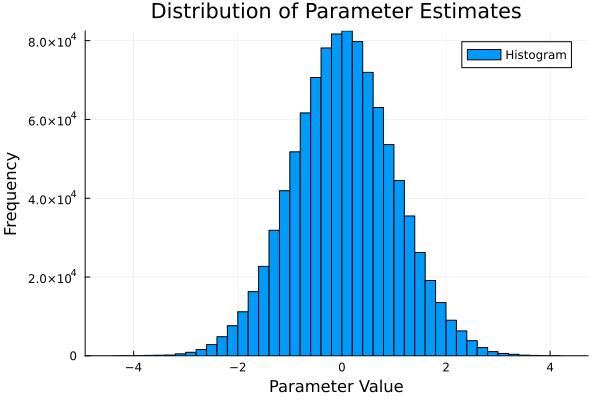

In [140]:
using Plots
#using KernelDensity

# Assuming p_traj is a 100 by N_steps array of parameter samples

# Extract samples for the first parameter
first_parameter_samples = p_traj[1, :]

# Plot histogram of the samples
histogram(first_parameter_samples, bins=50, xlabel="Parameter Value", ylabel="Frequency", label="Histogram", title="Distribution of Parameter Estimates")

# Plot KDE of the samples
#kde_estimate = kde(first_parameter_samples)
#plot!(kde_estimate.x, kde_estimate.density, linewidth=2, linecolor=:red, label="KDE")


In [131]:
println(w)

[0.0744408785614394; 0.07686905091515059; 0.012620212616560978; -0.12499641484796829; -0.1223102543555834; 0.1267548354881701; 0.19613529632693227; -0.022632859615247136; -0.013935442436803207; -0.05181722901686428; 0.016817137950347283; 0.09000803591915664; -0.0800032377090131; -0.12819426112358687; 0.018459505205548166; 0.09631580376025259; 0.09112187619676072; -0.1135791102646299; -0.11859397646027336; -0.09252694547330796; -0.05937564544713314; 0.00684050496991382; 0.04872150497186859; -0.14375290519973083; 0.05404789703197378; 0.06144595749643079; 0.12098388502650664; 0.10355362275336652; -0.14585003707540864; -0.03238781338792784; -0.01663354434302576; -0.016380573566331318; -0.13608830120282428; 0.06415065981365911; -0.0495210817266317; 0.023100966102115088; 0.02213617263815317; 0.016279285311257802; -0.1026367233667627; -0.20716177170828984; 0.11595914453735763; -0.1948763843832683; -0.10052447195975887; -0.0485049959361969; -0.13898828024868135; 0.10783895448979366; -0.0665976